Now that the NBA season is done, we have complete data from this year's NBA rookies. In the past I have tried to predict NBA rookies' future performance using [regression](http://www.danvatterott.com/blog/2016/03/20/predicting-career-performance-from-rookie-performance/) [models](http://www.danvatterott.com/blog/2016/04/08/revisiting-nba-career-predictions-from-rookie-performance/). In this post I am again trying to predict rookies' future performance, but now using using a [classification approach](https://en.wikipedia.org/wiki/Statistical_classification). When using a classification approach, I predict whether player X will be a "great," "average," or "poor" player rather than predicting exactly how productive player X will be.

Much of this post re-uses code from the previous posts, so I skim over some of the repeated code. 

As usual, I will post all code as a jupyter notebook on my [github](https://github.com/dvatterott/jupyter_notebooks).

In [1]:
#import some libraries and tell ipython we want inline figures rather than interactive figures. 
import matplotlib.pyplot as plt, pandas as pd, numpy as np, matplotlib as mpl

from __future__ import print_function

%matplotlib inline
plt.style.use('ggplot') #im addicted to ggplot. so pretty.

Load the data. Reminder - this data is available on my [github](https://github.com/dvatterott/nba_project).

In [2]:
rookie_df = pd.read_pickle('nba/nba_bballref_rookie_stats_2016_Apr_16.pkl') #here's the rookie year data

rook_games = rookie_df['Career Games']>50 #only attempting to predict players that have played at least 50 games
rook_year = rookie_df['Year']>1980 #only attempting to predict players from after 1980

#remove rookies from before 1980 and who have played less than 50 games. I also remove some features that seem irrelevant or unfair
rookie_df_games = rookie_df[rook_games & rook_year] #only players with more than 50 games. 
rookie_df_drop = rookie_df_games.drop(['Year','Career Games','Name'],1)

Load more data, and normalize the data for the [PCA transformation](https://en.wikipedia.org/wiki/Principal_component_analysis). 

In [3]:
from sklearn.preprocessing import StandardScaler

df = pd.read_pickle('nba/nba_bballref_career_stats_2016_Apr_15.pkl')
df = df[df['G']>50]
df_drop = df.drop(['Year','Name','G','GS','MP','FG','FGA','FG%','3P','2P','FT','TRB','PTS','ORtg','DRtg','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'],1)
X = df_drop.as_matrix() #take data out of dataframe
ScaleModel = StandardScaler().fit(X) #make sure each feature has 0 mean and unit variance. 
X = ScaleModel.transform(X)

In the past I used [k-means](https://en.wikipedia.org/wiki/K-means_clustering) to group players according to their performance (see my post on [grouping players](http://www.danvatterott.com/blog/2016/02/21/grouping-nba-players/) for more info). Here, I use a [gaussian mixture model](https://en.wikipedia.org/wiki/Mixture_model) (GMM) to group the players. I use the GMM model because it assigns each player a "soft" label rather than a "hard" label. By soft label I mean that a player simultaneously belongs to several groups. For instance, Russell Westbrook belongs to both my "point guard" group and my "scorers" group. K-means uses hard labels where each player can only belong to one group. I think the GMM model provides a more accurate representation of players, so I've decided to use it in this post. Maybe in a future post I will spend more time describing it. 

For anyone wondering, the GMM groupings looked pretty similar to the k-means groupings. 

In [4]:
from sklearn.mixture import GMM
from sklearn.decomposition import PCA

reduced_model = PCA(n_components=5, whiten=True).fit(X)
reduced_data = reduced_model.transform(X) #transform data into the 5 PCA components space

g = GMM(n_components=6).fit(reduced_data) #6 clusters. like the k-means model
new_labels = g.predict(reduced_data)

predictions = g.predict_proba(reduced_data) #generate values describing "how much" each player belongs to each group 
for x in np.unique(new_labels):
    Label = 'Category%d' % x 
    df[Label] = predictions[:,x] 

In this past I have attempted to predict win shares per 48 minutes. I am using win shares as a dependent variable again, but I want to categorize players. 

Below I create a histogram of players' win shares per 48. 

I split players into 4 groups which I will refer to as "bad," "below average," "above average," and "great": Poor players are the bottom 10% in win shares per 48, Below average are the 10-50th percentiles, Above average and 50-90th percentiles, Great are the top 10%. This assignment scheme is relatively arbitrary; the model performs similarly with different assignment schemes. 

[0.096314496314496317,
 0.40196560196560199,
 0.39950859950859952,
 0.10221130221130222]

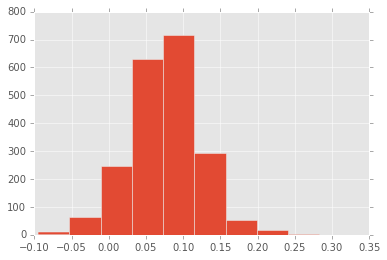

In [5]:
plt.hist(df['WS/48']);
df['perf_cat'] = 0
df.loc[df['WS/48'] < np.percentile(df['WS/48'],10),'perf_cat'] = 1 #category 1 players are bottom 10%
df.loc[(df['WS/48'] < np.percentile(df['WS/48'],50)) & (df['WS/48'] >= np.percentile(df['WS/48'],10)),'perf_cat'] = 2
df.loc[(df['WS/48'] < np.percentile(df['WS/48'],90)) & (df['WS/48'] >= np.percentile(df['WS/48'],50)),'perf_cat'] = 3
df.loc[df['WS/48'] >= np.percentile(df['WS/48'],90),'perf_cat'] = 4 #category 4 players are top 10%
perc_in_cat = [np.mean(df['perf_cat']==x) for x in np.unique(df['perf_cat'])];
perc_in_cat #print % of palyers in each category as a sanity check

My goal is to use rookie year performance to classify players into these 4 categories. I have a big matrix with lots of data about rookie year performance, but the reason that I grouped player using the GMM is because I suspect that players in the different groups have different "paths" to success. I am including the groupings in my classification model and computing interaction terms. The interaction terms will allow rookie performance to produce different predictions for the different groups. 

By including interaction terms, I include quite a few predictor features. I've printed the number of predictor features and the number of predicted players below. 

In [6]:
from sklearn import preprocessing

df_drop = df[df['Year']>1980]
for x in np.unique(new_labels):
    Label = 'Category%d' % x 
    rookie_df_drop[Label] = df_drop[Label] #give rookies the groupings produced by the GMM model

X = rookie_df_drop.as_matrix() #take data out of dataframe   
    
poly = preprocessing.PolynomialFeatures(2,interaction_only=True) #create interaction terms.
X = poly.fit_transform(X)

Career_data = df[df['Year']>1980]
Y = Career_data['perf_cat'] #get predictor data
print(np.shape(X))
print(np.shape(Y))

(1703, 1432)
(1703,)


Now that I have all the features, it's time to try and predict which players will be poor, below average, above average, and great. To create these predictions, I will use a [logistic regression model](https://en.wikipedia.org/wiki/Logistic_regression). 

Because I have so many predictors, correlation between predicting features and over-fitting the data are major concerns. I use [regularization](http://stats.stackexchange.com/questions/4272/when-to-use-regularization-methods-for-regression) and [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) to combat these issues. 

Specifically, I am using [l2 regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization) and k-fold 5 cross-validation. Within the cross-validation, I am trying to estimate how much regularization is appropriate. 

Some important notes - I am using "balanced" weights which tells the model that worse to incorrectly predict the poor and great players than the below average and above average players. I do this because I don't want the model to completely ignore the less frequent classifications. Second, I use the multi_class multinomial because it limits the number of models I have to fit. 

In [7]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score 

logreg = linear_model.LogisticRegressionCV(Cs=[0.0008], cv=5, penalty='l2',n_jobs=-1, class_weight='balanced', 
                                           max_iter=15000, multi_class='multinomial')
      
est = logreg.fit(X, Y)
score = accuracy_score(Y,est.predict(X)) #calculate the % correct 
print(score)

0.74398120963


In [8]:
est.coef_

array([[ -1.05870807e-05,  -1.28221968e-04,  -4.19771427e-05, ...,
         -1.72498634e-05,   1.29706001e-05,  -1.41648879e-05],
       [  1.30563687e-05,   1.06377534e-04,   4.50958451e-04, ...,
         -3.20193240e-05,  -3.42511408e-05,   2.40662680e-05],
       [  1.72550869e-05,   1.92504540e-04,   9.22952518e-05, ...,
         -3.00713309e-06,  -3.32536118e-05,   5.07696996e-06],
       [ -1.97243749e-05,  -1.70660106e-04,  -5.01276560e-04, ...,
          5.22763205e-05,   5.45341525e-05,  -1.49783501e-05]])

Okay, the model did pretty well, but lets look at where the errors are coming from. To visualize the models accuracy, I am using a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). In a confusion matrix, every item on the diagnonal is a correctly classified item. Every item off the diagonal is incorrectly classified. The color bar's axis is the percent correct. So the dark blue squares represent cells with more items. 

It seems the model is best at predicting poor players and great players. It makes more errors when trying to predict the more average players. 

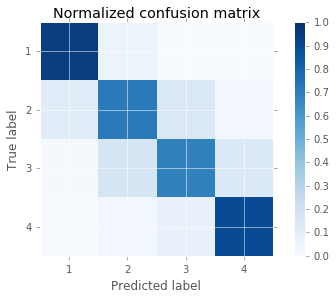

In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y, est.predict(X))

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap,vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(df['perf_cat'])))
    plt.xticks(tick_marks, np.unique(df['perf_cat']))
    plt.yticks(tick_marks, np.unique(df['perf_cat']))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

In [10]:
cm

array([[167,   9,   0,   0],
       [ 82, 507, 104,  18],
       [  7, 107, 443,  91],
       [  1,   4,  13, 150]])

Lets look at what the model predicts for this year's rookies. Below I modified two functions that I wrote for a previous post. The first function finds a particular year's draft picks. The second function produces predictions for each draft pick.

In [11]:
def gather_draftData(Year):

    import urllib2
    from bs4 import BeautifulSoup
    import pandas as pd
    import numpy as np

    draft_len = 30

    def convert_float(val):
        try:
            return float(val)
        except ValueError:
            return np.nan

    url = 'http://www.basketball-reference.com/draft/NBA_'+str(Year)+'.html'
    html = urllib2.urlopen(url)
    soup = BeautifulSoup(html,"lxml")

    draft_num = [soup.findAll('tbody')[0].findAll('tr')[i].findAll('td')[0].text for i in range(draft_len)]
    draft_nam = [soup.findAll('tbody')[0].findAll('tr')[i].findAll('td')[3].text for i in range(draft_len)]

    draft_df = pd.DataFrame([draft_num,draft_nam]).T
    draft_df.columns = ['Number','Name']
    df.index = range(np.size(df,0))
    return draft_df

def player_prediction__regressionModel(PlayerName):

    clust_df = pd.read_pickle('nba/nba_bballref_career_stats_2016_Apr_15.pkl')
    clust_df = clust_df[clust_df['Name']==PlayerName]
    clust_df = clust_df.drop(['Year','Name','G','GS','MP','FG','FGA','FG%','3P','2P','FT','TRB','PTS','ORtg','DRtg','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'],1)
    new_vect = ScaleModel.transform(clust_df.as_matrix().reshape(1,-1))
    reduced_data = reduced_model.transform(new_vect)
    predictions = g.predict_proba(reduced_data)
    for x in np.unique(new_labels):
        Label = 'Category%d' % x 
        clust_df[Label] = predictions[:,x] 

    Predrookie_df = pd.read_pickle('nba/nba_bballref_rookie_stats_2016_Apr_16.pkl')
    Predrookie_df = Predrookie_df[Predrookie_df['Name']==PlayerName]
    Predrookie_df = Predrookie_df.drop(['Year','Career Games','Name'],1)
    for x in np.unique(new_labels):
        Label = 'Category%d' % x 
        Predrookie_df[Label] = clust_df[Label] #give rookies the groupings produced by the GMM model
    predX = Predrookie_df.as_matrix() #take data out of dataframe
    predX = poly.fit_transform(predX)
    predictions2 = est.predict_proba(predX)
    return {'Name':PlayerName,'Group':predictions,'Prediction':predictions2[0]}

Below I create a plot depicting the model's predictions. On the y-axis are the four classifications. On the x-axis are the players from the 2015 draft. Each cell in the plot is the probability of a player belonging to one of the classifications. Again, dark blue means a cell or more likely. Good news for us T-Wolves fans! The model loves KAT. 

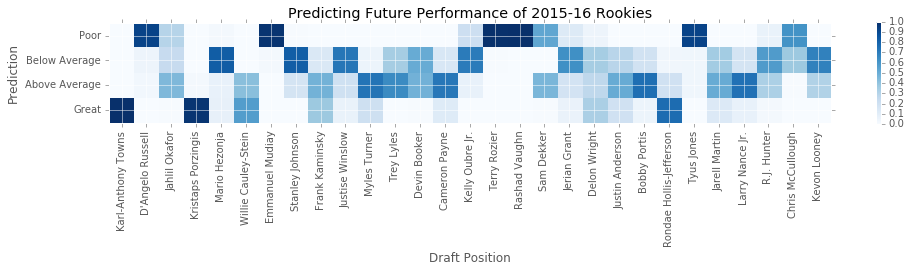

In [12]:
draft_df = gather_draftData(2015)

draft_df['Name'][14] =  'Kelly Oubre Jr.' #annoying name inconsistencies 

plt.subplots(figsize=(14,6));

draft_df = draft_df.drop(25, 0) #spurs' 1st round pick has not played yet

predictions = []
for name in draft_df['Name']:
    draft_num = draft_df[draft_df['Name']==name]['Number']
    predict_dict = player_prediction__regressionModel(name)
    predictions.append(predict_dict['Prediction'])
    
plt.imshow(np.array(predictions).T, interpolation='nearest', cmap=plt.cm.Blues,vmin=0.0, vmax=1.0)
plt.title('Predicting Future Performance of 2015-16 Rookies')
plt.colorbar(shrink=0.25)
tick_marks = np.arange(len(np.unique(df['perf_cat'])))
plt.xticks(range(0,29),draft_df['Name'],rotation=90)
plt.yticks(range(0,4), ['Poor','Below Average','Above Average','Great'])
plt.tight_layout()
plt.ylabel('Prediction')
plt.xlabel('Draft Position');

In [13]:
predict_dict

{'Group': array([[  1.28360145e-10,   6.78132141e-01,   2.68364463e-01,
           5.35023327e-02,   1.06311569e-06,   8.58862383e-19]]),
 'Name': u'Kevon Looney',
 'Prediction': array([  1.24089777e-09,   6.87112038e-01,   3.12876463e-01,
          1.14983019e-05])}

In [15]:
draft_df['Name'].to_csv('nba_draft_names.csv')

In [21]:
pd.DataFrame(predictions,index = draft_df['Name'])

,0,1,2,3
Name,,,,
Karl-Anthony Towns,2.633485e-32,3.542443e-09,5.741257e-06,9.999943e-01
D'Angelo Russell,9.232835e-01,4.896650e-02,2.773871e-02,1.127998e-05
Jahlil Okafor,2.973934e-01,2.435993e-01,4.518458e-01,7.161466e-03
Kristaps Porzingis,8.397272e-20,9.223810e-06,2.090147e-02,9.790893e-01
Mario Hezonja,2.194004e-02,8.245541e-01,7.268120e-02,8.082470e-02
Willie Cauley-Stein,7.933458e-12,1.328758e-03,4.255889e-01,5.730823e-01
Emmanuel Mudiay,9.842721e-01,1.564085e-02,8.706128e-05,1.078438e-21
Stanley Johnson,5.881348e-03,8.211375e-01,1.729058e-01,7.538813e-05
Frank Kaminsky,5.564819e-07,1.466050e-01,4.775813e-01,3.758131e-01


In [18]:
predictions

[array([  2.63348531e-32,   3.54244256e-09,   5.74125739e-06,
          9.99994255e-01]),
 array([  9.23283508e-01,   4.89665005e-02,   2.77387120e-02,
          1.12799844e-05]),
 array([ 0.29739343,  0.24359934,  0.45184576,  0.00716147]),
 array([  8.39727218e-20,   9.22380954e-06,   2.09014653e-02,
          9.79089311e-01]),
 array([ 0.02194004,  0.82455406,  0.0726812 ,  0.0808247 ]),
 array([  7.93345845e-12,   1.32875811e-03,   4.25588942e-01,
          5.73082300e-01]),
 array([  9.84272085e-01,   1.56408541e-02,   8.70612756e-05,
          1.07843756e-21]),
 array([  5.88134794e-03,   8.21137501e-01,   1.72905763e-01,
          7.53881349e-05]),
 array([  5.56481854e-07,   1.46605014e-01,   4.77581338e-01,
          3.75813092e-01]),
 array([  1.50342076e-05,   7.29201945e-01,   2.00840312e-01,
          6.99427090e-02]),
 array([  3.76890106e-06,   5.36339144e-02,   7.37192249e-01,
          2.09170068e-01]),
 array([  8.51504831e-08,   3.49969300e-01,   6.48985851e-01,
    